In [1]:
import seaborn as sns, pandas as pd, numpy as np

In [2]:
data = pd.read_csv("data/classdata-fixed.csv")

In [3]:
data = data.drop(["Unnamed: 0"], axis=1)

In [4]:
data.dtypes.value_counts()

float64    6
int64      1
dtype: int64

In [5]:
data.fault.value_counts()

0       2365
1011    1134
1111    1133
1001    1129
111     1096
110     1004
Name: fault, dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder

le =LabelEncoder()
data['fault'] = le.fit_transform(data.fault)
data['fault'].sample(5)

5596    0
630     3
6288    0
1196    4
5444    5
Name: fault, dtype: int64

In [7]:
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

trill_index = np.tril_indices_from(corr_values)

corr_array = np.array(corr_values)
corr_array[np.tril_indices_from(corr_values)] = np.nan

corr_values = pd.DataFrame(corr_array,columns = corr_values.columns, index= corr_values.index)

corr_values = (corr_values
              .stack()
              .to_frame()
              .reset_index()
              .rename(columns={'level_0':'feature_1',
                     'level_1':'feature_2',
                     0:'correlation'}))

corr_values['abs_correlation'] = corr_values.correlation.abs()

In [8]:
data

,Ia,Ib,Ic,Va,Vb,Vc,fault
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,3
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,3
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,3
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,3
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,3
...,...,...,...,...,...,...,...
7856,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,0
7857,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,0
7858,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,0
7859,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,0


In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
cols= ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
data[cols] = sc.fit_transform(data[cols])

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

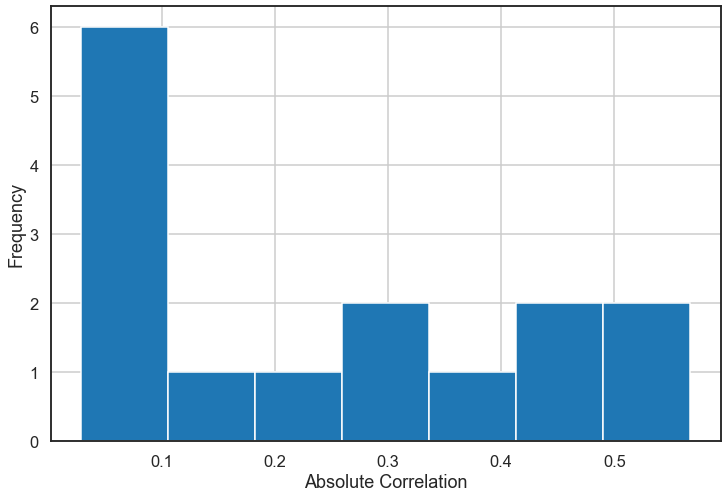

In [11]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=7, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
corr_values.sort_values('correlation', ascending=False)

,feature_1,feature_2,correlation,abs_correlation
4,Ia,Vc,0.246043,0.246043
11,Ic,Vc,0.122919,0.122919
2,Ia,Va,0.035682,0.035682
7,Ib,Vb,0.032101,0.032101
6,Ib,Va,0.029118,0.029118
10,Ic,Vb,-0.056967,0.056967
8,Ib,Vc,-0.060023,0.060023
9,Ic,Va,-0.069137,0.069137
3,Ia,Vb,-0.274612,0.274612
1,Ia,Ic,-0.276457,0.276457


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1,
                                         test_size=0.3,
                                         random_state=13)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.fault))

X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'fault']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'fault']

In [14]:
y_train.value_counts(normalize=True)

0    0.300800
4    0.144311
5    0.144129
3    0.143584
2    0.139404
1    0.127772
Name: fault, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.300975
4    0.144129
5    0.144129
3    0.143705
2    0.139466
1    0.127596
Name: fault, dtype: float64

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [17]:
from sklearn.linear_model import LogisticRegressionCV

lr_l1 = LogisticRegressionCV(Cs=50, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

lr_l2 = LogisticRegressionCV(Cs=50, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

In [18]:
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                               codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(6)

lr                                                     l1            \
          0         1         2         3         4         5    0    1    2   
1  0.152042 -0.055440 -0.147047  0.236445 -0.423873  0.126398  0.0  0.0  0.0   
3 -0.045385  0.000477  0.024621 -0.046009  0.049120  0.057160  0.0  0.0  0.0   
4  0.071231  0.009494 -0.086412  0.084892 -0.077789 -0.063830  0.0  0.0  0.0   
5 -0.029890 -0.010113  0.064844 -0.043211  0.033059  0.011299  0.0  0.0  0.0   
2 -0.180681  0.218423  0.093796  0.066434 -0.425774  0.372332  0.0  0.0  0.0   
0 -0.026338  0.012460 -0.066390  0.206536 -0.269165  0.162871  0.0  0.0  0.0   

                        l2                                                    
     3    4    5         0         1         2         3         4         5  
1  0.0  0.0  0.0  0.066385 -0.008777 -0.009602  0.007222 -0.006884 -0.006738  
3  0.0  0.0  0.0 -0.017042 -0.001367  0.000708 -0.004133  0.003798  0.003086  
4  0.0  0.0  0.0  0.032709 -0.000340 -0.006854  0.004369 -0.002177 -0.008693  
5  0.0  0.0  0.0 -0.017293  0.001630  0.006313 -0.000567 -0.001351  0.005951  
2  0.0  0.0  0.0 -0.069238  0.011995  0.010337 -0.007049 -0.007988  0.014456  
0  0.0  0.0  0.0 -0.012432 -0.001624 -0.000108  0.004365  0.001831  0.001821

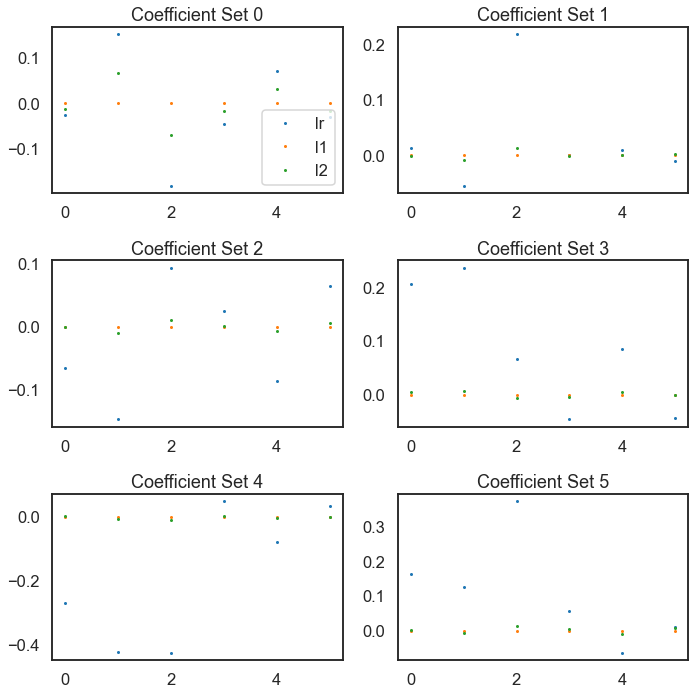

In [19]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for loc, ax in enumerate(axList):
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))
    
plt.tight_layout()

In [20]:
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                               codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    
    y_prob.append(pd.DataFrame(mod.predict_proba(X_test), columns=coeff_label))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,0,0,5
1,0,0,3
2,0,0,3
3,0,0,3
4,5,0,5


In [21]:
y_test.head()

1426    4
964     3
7379    0
6829    0
4864    5
Name: fault, dtype: int64

In [22]:
from sklearn.preprocessing import label_binarize

label_binarize(y_test, classes=[0,1,2,3,4,5])

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0]])

In [23]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:
    
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
                        y_prob[lab],
                        average='weighted')
    
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall,
                             'fscore':fscore, 'accuracy':accuracy,
                             'auc':auc},
                            name=lab))
    
metrics = pd.concat(metrics, axis=1)

C:\Users\Purpl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Purpl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Purpl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [24]:
metrics

,lr,l1,l2
precision,0.145254,0.090586,0.102369
recall,0.328953,0.300975,0.197117
fscore,0.184111,0.139259,0.131534
accuracy,0.328953,0.300975,0.197117
auc,0.583693,0.500000,0.570336


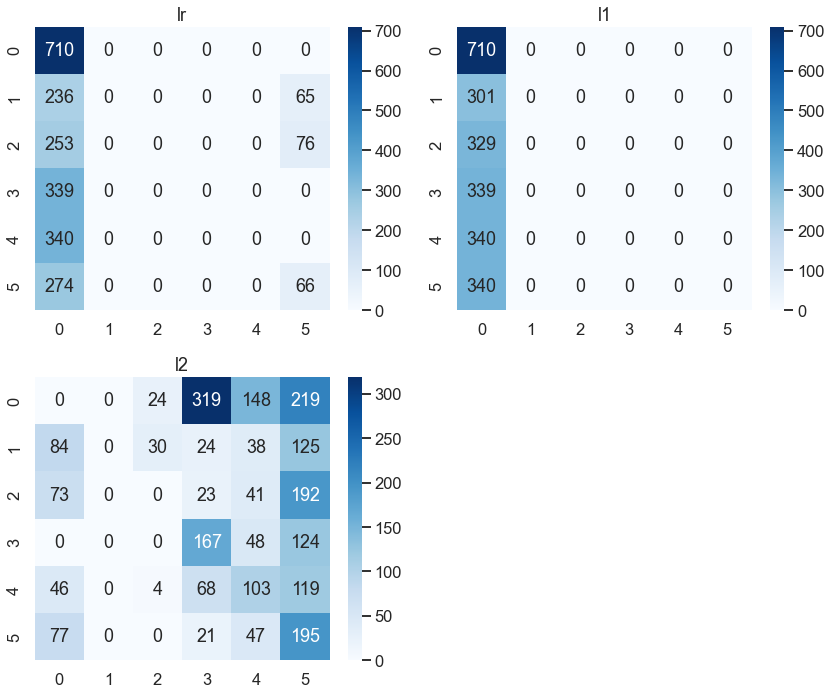

In [25]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap='Blues');
    ax.set(title=lab);
    
plt.tight_layout()